<a href="https://colab.research.google.com/github/NishatVasker/CSE303_Statics_for_data-science/blob/main/NISHAT_client.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install kaggle


In [5]:
from google.colab import files

# Upload the Kaggle API key file
uploaded = files.upload()


Saving kaggle.json to kaggle.json


In [6]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [7]:
# Download the dataset
!kaggle datasets download -d emmarex/plantdisease

# Unzip the downloaded dataset
!unzip -q plantdisease.zip -d plantdisease

100% 656M/658M [00:07<00:00, 72.4MB/s]
100% 658M/658M [00:07<00:00, 92.3MB/s]


In [9]:
import os
import random
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib import image as mpimg
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow_hub as hub
import keras
from keras import Model
from keras.models import Sequential
from keras.layers import Input, Dense, Flatten, GlobalAveragePooling2D, Reshape, LSTM
from tensorflow.keras.layers import Conv2D, MaxPooling2D  # Updated import
from keras.losses import CategoricalCrossentropy
from keras.optimizers import Adam
from keras.applications import MobileNetV2


In [11]:
dir = '/content/plantdisease/PlantVillage'
labels = os.listdir(dir)
labels

['Tomato_healthy',
 'Tomato_Bacterial_spot',
 'Potato___Late_blight',
 'Potato___Early_blight',
 'Potato___healthy',
 'Pepper__bell___Bacterial_spot',
 'Tomato__Tomato_mosaic_virus',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Pepper__bell___healthy',
 'Tomato_Leaf_Mold',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_Septoria_leaf_spot',
 'Tomato__Target_Spot',
 'Tomato__Tomato_YellowLeaf__Curl_Virus']

In [12]:
for label in labels:
    print(label, len(os.listdir(dir+'/'+label)))

Tomato_healthy 1591
Tomato_Bacterial_spot 2127
Potato___Late_blight 1000
Potato___Early_blight 1000
Potato___healthy 152
Pepper__bell___Bacterial_spot 997
Tomato__Tomato_mosaic_virus 373
Tomato_Spider_mites_Two_spotted_spider_mite 1676
Pepper__bell___healthy 1478
Tomato_Leaf_Mold 952
Tomato_Early_blight 1000
Tomato_Late_blight 1909
Tomato_Septoria_leaf_spot 1771
Tomato__Target_Spot 1404
Tomato__Tomato_YellowLeaf__Curl_Virus 3209


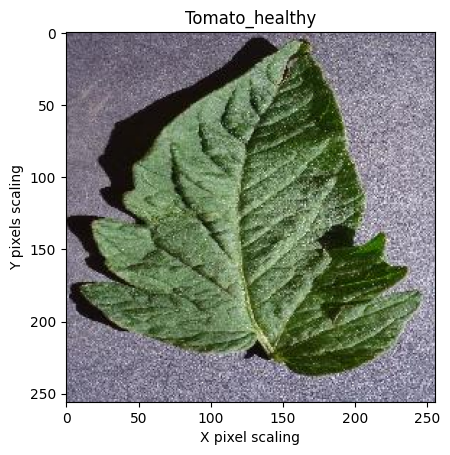

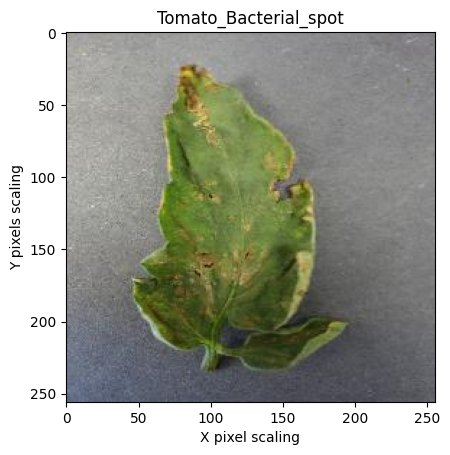

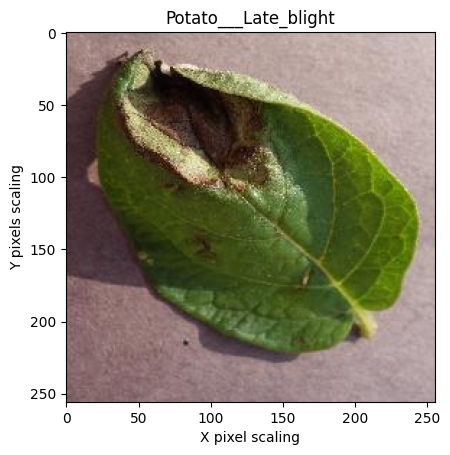

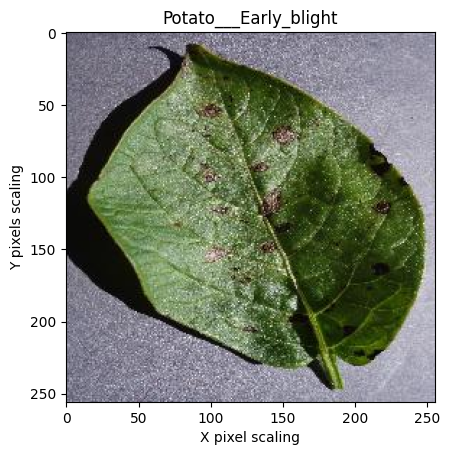

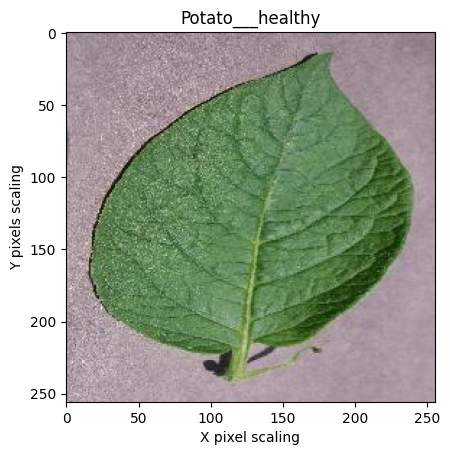

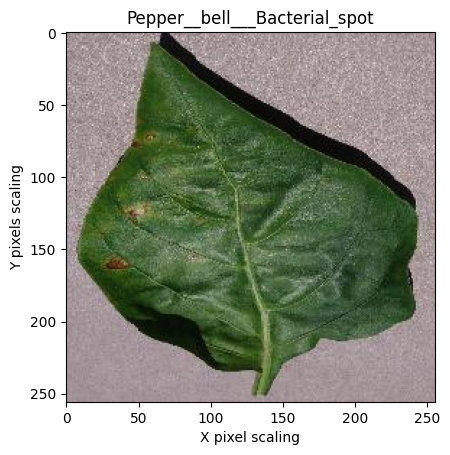

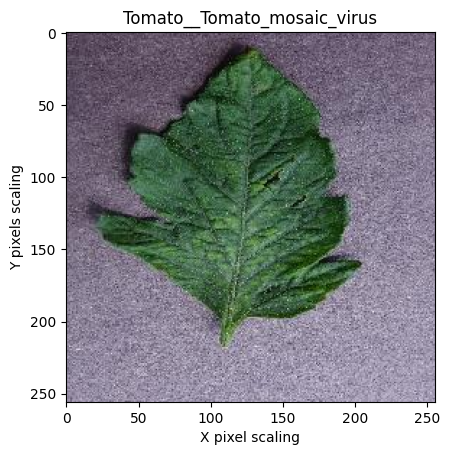

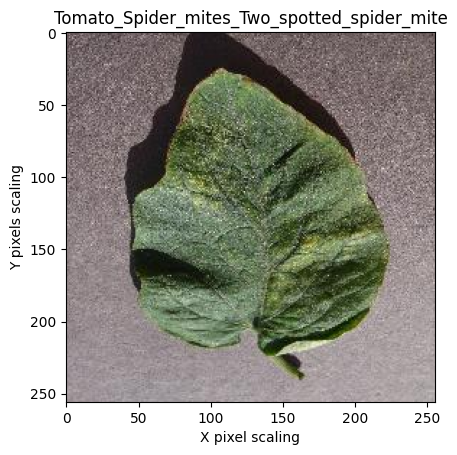

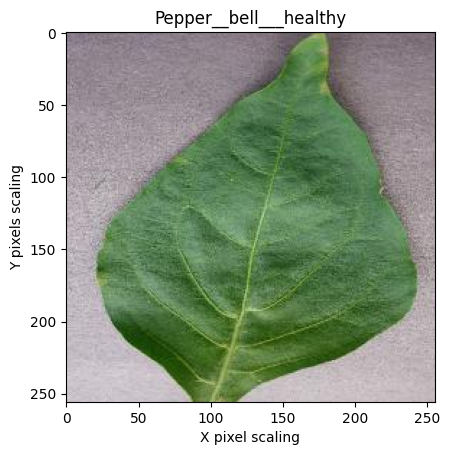

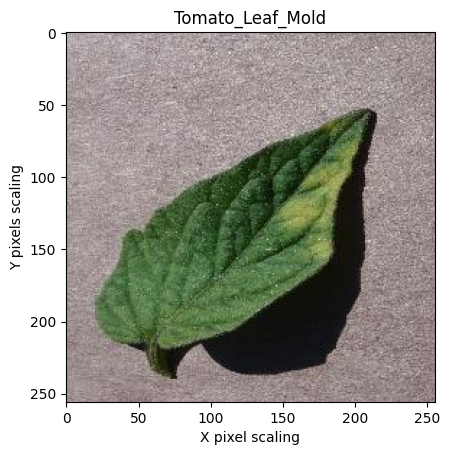

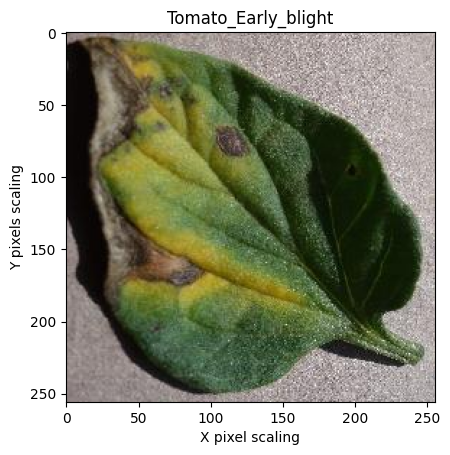

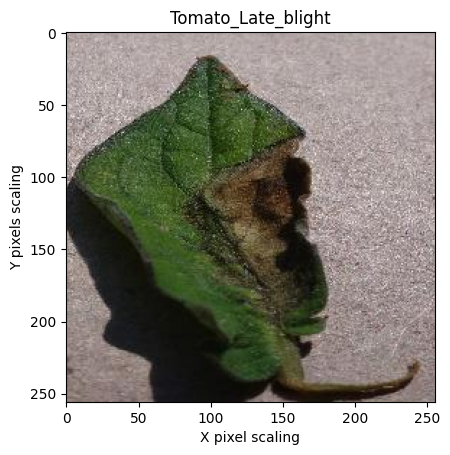

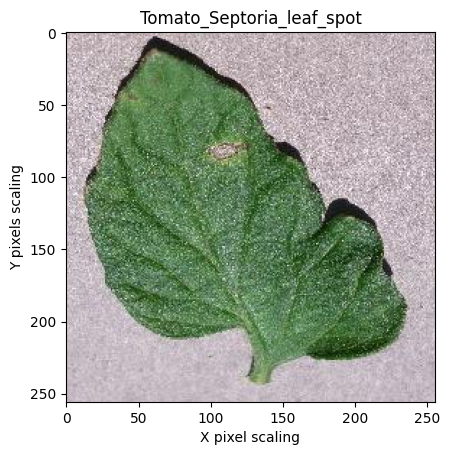

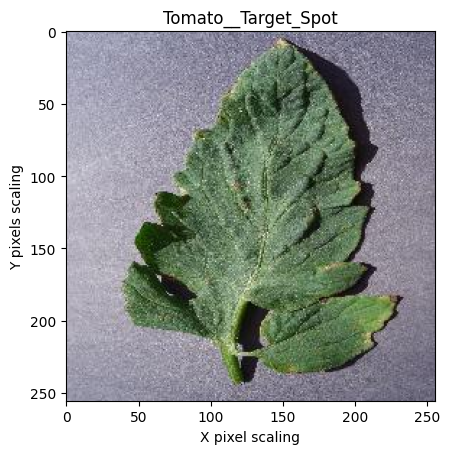

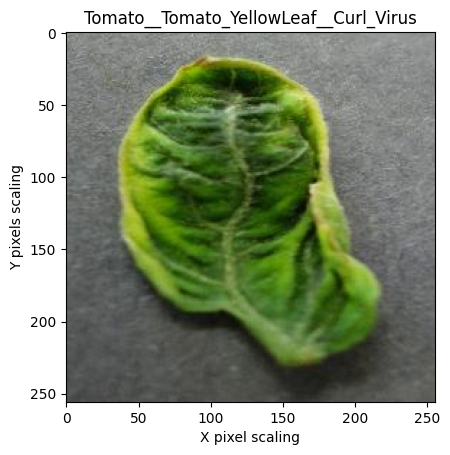

In [13]:
for label in labels:
    path = os.listdir(dir + '/' + label)
    img = dir + '/' + label + '/' + path[1]
    plt.title(label)
    plt.xlabel("X pixel scaling")
    plt.ylabel("Y pixels scaling")
    image = mpimg.imread(img)
    plt.imshow(image)
    plt.show()

In [14]:
datagen = ImageDataGenerator(
    samplewise_center=True,
    rotation_range=10,
    zoom_range = 0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=False,
    rescale=1./255,
    validation_split=0.20
)

train_data = datagen.flow_from_directory(
    dir,
    target_size=(64,64),
    batch_size=32,
    class_mode='categorical',
    shuffle=True,
    subset='training'
)
test_data = datagen.flow_from_directory(
    dir,
    target_size=(64,64),
    batch_size=32,
    shuffle=False,
    subset='validation'
)
validation_data = datagen.flow_from_directory(
    dir,
    target_size=(64,64),
    batch_size=32,
    shuffle=False,
    subset='validation'
)

Found 16516 images belonging to 15 classes.
Found 4122 images belonging to 15 classes.
Found 4122 images belonging to 15 classes.


Found 20638 images belonging to 15 classes.


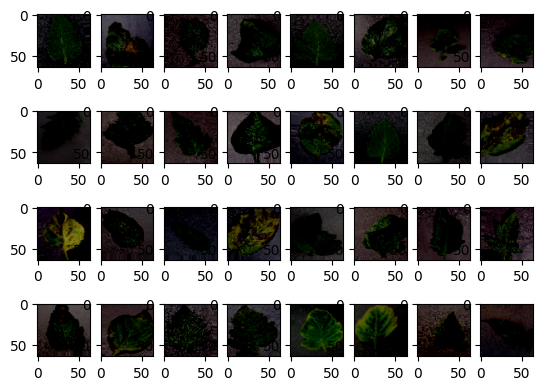

In [15]:
img_iter = datagen.flow_from_directory(dir,
                                       target_size=(64,64),
                                       batch_size=32)
x, y = img_iter.next()
fig, ax = plt.subplots(nrows=4, ncols=8)
for i in range(32):
    image = x[i]
    ax.flatten()[i].imshow(np.squeeze(image))
plt.show()

In [17]:
model=Sequential()
size=(64,64,3)
model.add(Conv2D(filters=8, kernel_size=(3,3), strides=(1,1), activation='relu', input_shape=size))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model.add(Conv2D(16, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(32, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(32, kernel_size=(3,3), activation='relu'))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(15, activation='softmax'))##class number,in example i have 8 classes so i have given 8

#Compiling the model
model.compile(loss=CategoricalCrossentropy(), optimizer=Adam(), metrics=['accuracy'])

#Training the model
base_model=model.fit(train_data, epochs=2, steps_per_epoch=len(train_data), validation_data=validation_data, validation_steps=len(validation_data))

Epoch 1/2
517/517 [==============================] - 110s 208ms/step - loss: 1.6556 - accuracy: 0.4597 - val_loss: 1.0187 - val_accuracy: 0.6749
Epoch 2/2
517/517 [==============================] - 125s 241ms/step - loss: 0.9073 - accuracy: 0.6928 - val_loss: 0.8008 - val_accuracy: 0.7259


In [18]:
print(base_model.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


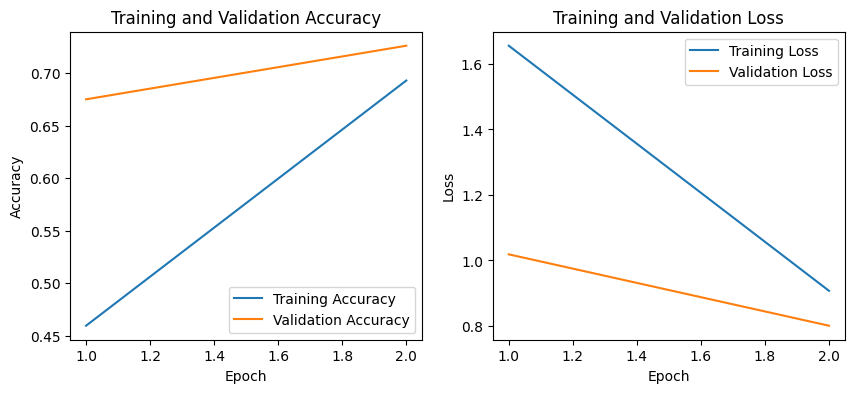

In [19]:
acc = base_model.history['accuracy']
val_acc = base_model.history['val_accuracy']
loss = base_model.history['loss']
val_loss = base_model.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [20]:
score = model.evaluate(test_data)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

129/129 [==============================] - 17s 133ms/step - loss: 0.8102 - accuracy: 0.7312
Test loss: 0.8101678490638733
Test accuracy: 0.7311984300613403


129/129 [==============================] - 14s 108ms/step - loss: 0.8156 - accuracy: 0.7246


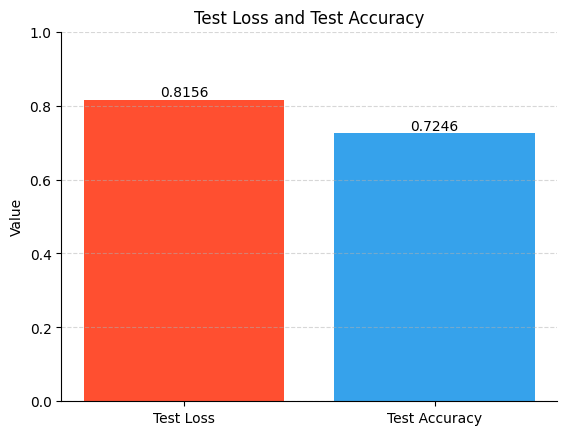

In [21]:
import matplotlib.pyplot as plt

# Calculate test loss and test accuracy
score = model.evaluate(test_data)
test_loss = score[0]
test_accuracy = score[1]

# Create labels and values for the plot
labels = ['Test Loss', 'Test Accuracy']
values = [test_loss, test_accuracy]

# Set colors for the bars
colors = ['#FF4F30', '#36A2EB']

# Create a figure and axis object
fig, ax = plt.subplots()

# Plot the bar chart
bars = ax.bar(labels, values, color=colors)

# Add labels and values on top of each bar
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height,
            f'{height:.4f}', ha='center', va='bottom')

# Customize the plot
plt.ylabel('Value')
plt.title('Test Loss and Test Accuracy')
plt.ylim([0, 1])  # Set y-axis limit to range from 0 to 1
plt.grid(axis='y', linestyle='--', alpha=0.5)  # Add horizontal grid lines

# Remove the top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Show the plot
plt.show()


In [22]:
score = model.evaluate(test_data)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

129/129 [==============================] - 14s 111ms/step - loss: 0.8064 - accuracy: 0.7215
Test loss: 0.8063984513282776
Test accuracy: 0.7214944362640381


129/129 [==============================] - 14s 111ms/step - loss: 0.8169 - accuracy: 0.7242


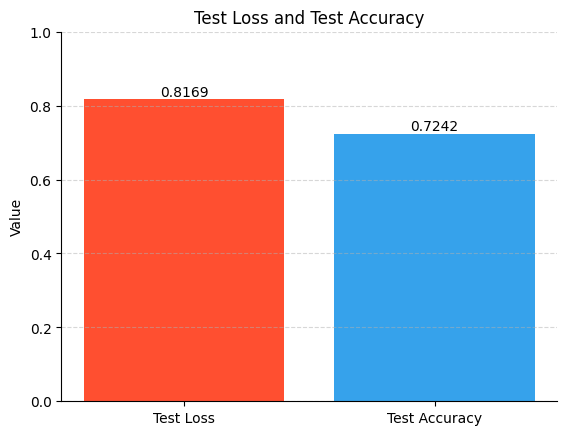

In [23]:
import matplotlib.pyplot as plt

# Calculate test loss and test accuracy
score = model.evaluate(test_data)
test_loss = score[0]
test_accuracy = score[1]

# Create labels and values for the plot
labels = ['Test Loss', 'Test Accuracy']
values = [test_loss, test_accuracy]

# Set colors for the bars
colors = ['#FF4F30', '#36A2EB']

# Create a figure and axis object
fig, ax = plt.subplots()

# Plot the bar chart
bars = ax.bar(labels, values, color=colors)

# Add labels and values on top of each bar
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height,
            f'{height:.4f}', ha='center', va='bottom')

# Customize the plot
plt.ylabel('Value')
plt.title('Test Loss and Test Accuracy')
plt.ylim([0, 1])  # Set y-axis limit to range from 0 to 1
plt.grid(axis='y', linestyle='--', alpha=0.5)  # Add horizontal grid lines

# Remove the top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Show the plot
plt.show()


In [24]:
# Evaluate the model on the train, test, and validation data
train_acc = model.evaluate(train_data, verbose=0)[1]
test_acc = model.evaluate(test_data, verbose=0)[1]
val_acc = model.evaluate(validation_data, verbose=0)[1]

# Print out the validation accuracies for the train, test, and validation data
print('Train accuracy:', train_acc)
print('Test accuracy:', test_acc)
print('Validation accuracy:', val_acc)

Train accuracy: 0.7251150608062744
Test accuracy: 0.7185832262039185
Validation accuracy: 0.7268316149711609


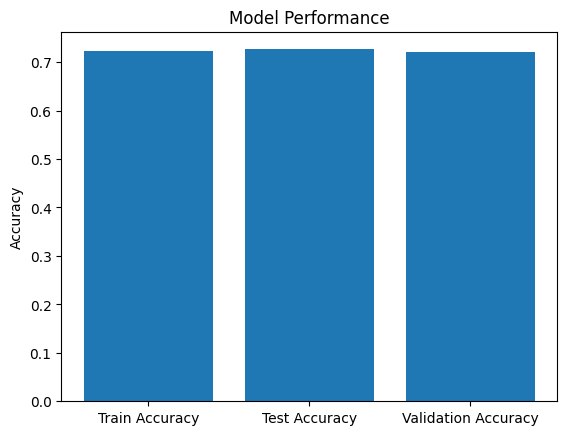

In [25]:
import matplotlib.pyplot as plt

# Calculate train, test, and validation accuracies
train_acc = model.evaluate(train_data, verbose=0)[1]
test_acc = model.evaluate(test_data, verbose=0)[1]
val_acc = model.evaluate(validation_data, verbose=0)[1]

# Create labels and values for the plot
labels = ['Train Accuracy', 'Test Accuracy', 'Validation Accuracy']
values = [train_acc, test_acc, val_acc]

# Plot the diagram
plt.bar(labels, values)
plt.ylabel('Accuracy')
plt.title('Model Performance')
plt.show()


In [26]:
predict=model.predict(test_data)
# predict the class label
y_classes = predict.argmax(axis=-1)
y_classes

129/129 [==============================] - 14s 109ms/step


array([ 3,  0, 11, ..., 14, 14, 14])

129/129 [==============================] - 14s 108ms/step


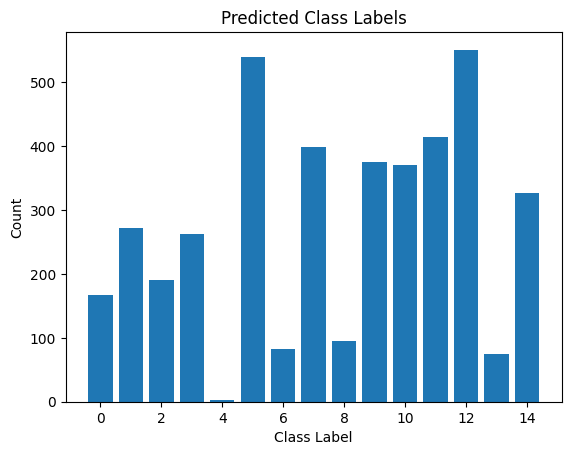

In [27]:
import matplotlib.pyplot as plt
import numpy as np

# Make predictions on the test data
predict = model.predict(test_data)

# Get the predicted class labels
y_classes = predict.argmax(axis=-1)

# Count the occurrences of each class label
unique_labels, label_counts = np.unique(y_classes, return_counts=True)

# Plot the graph
plt.bar(unique_labels, label_counts)
plt.xlabel('Class Label')
plt.ylabel('Count')
plt.title('Predicted Class Labels')
plt.show()


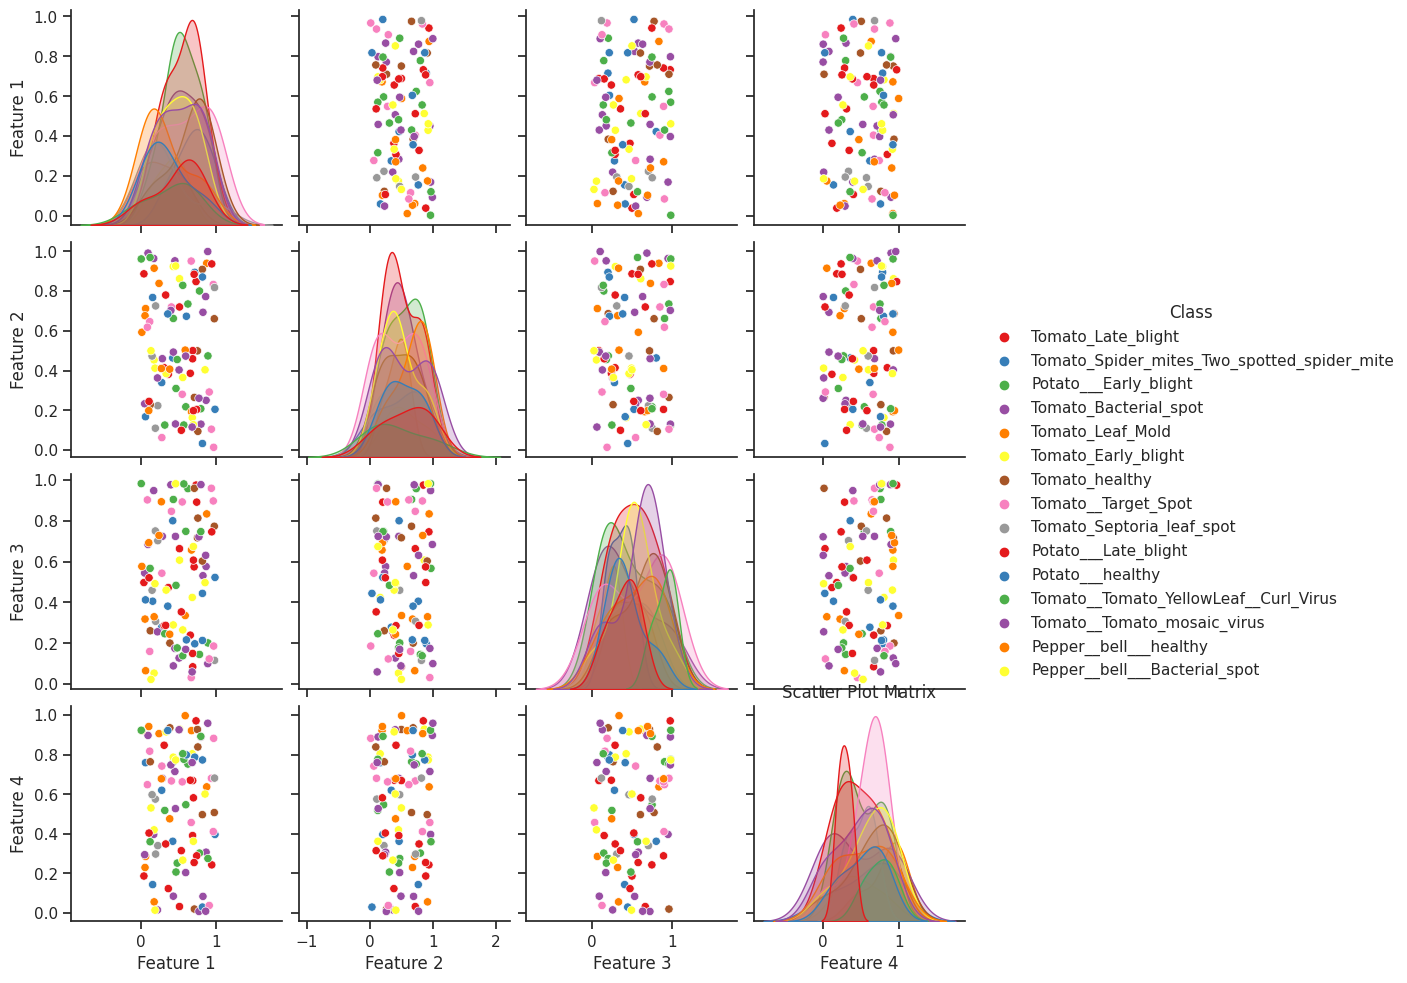

In [28]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Example data
class_labels = ['Pepper__bell___Bacterial_spot',
 'Potato___healthy',
 'Tomato_Leaf_Mold',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato_Bacterial_spot',
 'Tomato_Septoria_leaf_spot',
 'Tomato_healthy',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Tomato_Early_blight',
 'Tomato__Target_Spot',
 'Pepper__bell___healthy',
 'Potato___Late_blight',
 'Tomato_Late_blight',
 'Potato___Early_blight',
 'Tomato__Tomato_mosaic_virus']
data = pd.DataFrame(np.random.rand(100, 4), columns=['Feature 1', 'Feature 2', 'Feature 3', 'Feature 4'])
data['Class'] = np.random.choice(class_labels, size=100)





# Create a scatter plot matrix
sns.set(style="ticks")
sns.pairplot(data, hue='Class', palette='Set1')
plt.title('Scatter Plot Matrix')
plt.show()



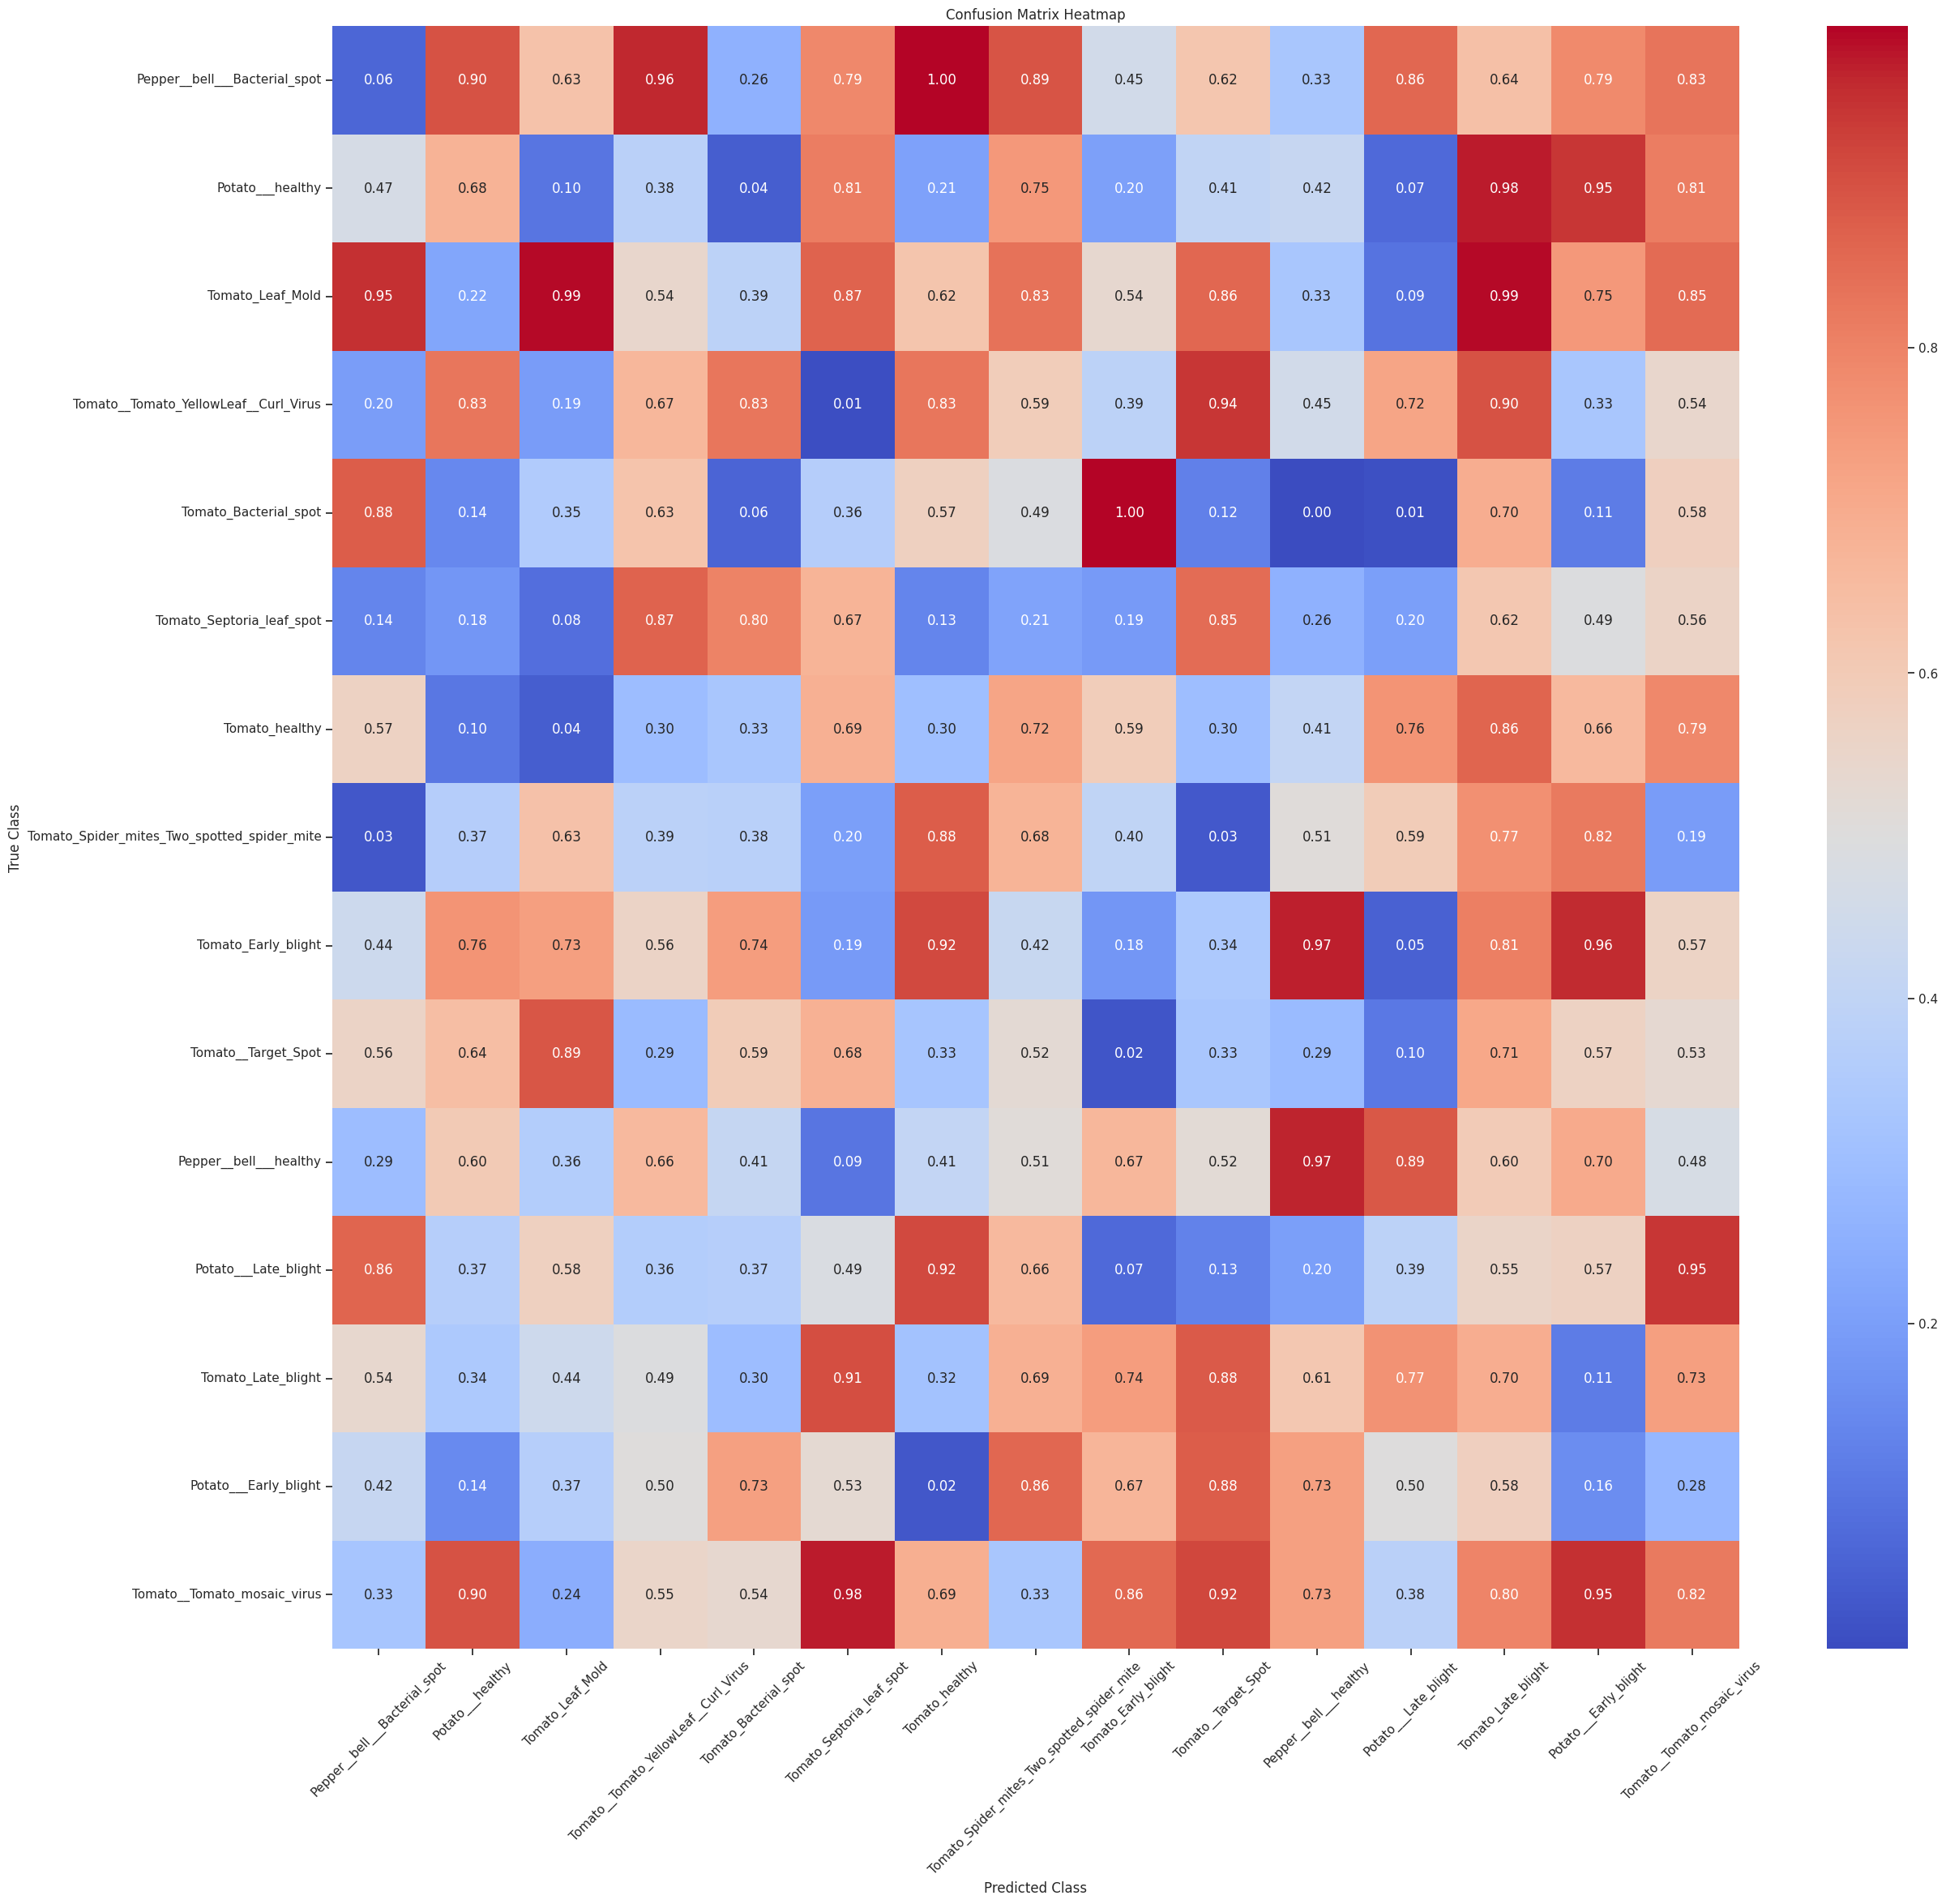

In [29]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Example data
class_labels = ['Pepper__bell___Bacterial_spot',
 'Potato___healthy',
 'Tomato_Leaf_Mold',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato_Bacterial_spot',
 'Tomato_Septoria_leaf_spot',
 'Tomato_healthy',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Tomato_Early_blight',
 'Tomato__Target_Spot',
 'Pepper__bell___healthy',
 'Potato___Late_blight',
 'Tomato_Late_blight',
 'Potato___Early_blight',
 'Tomato__Tomato_mosaic_virus']
data = np.random.rand(15, 15)

# Create a heatmap
plt.figure(figsize=(28, 26))
sns.heatmap(data, cmap='coolwarm', annot=True, fmt='.2f')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.title('Confusion Matrix Heatmap')
plt.xticks(np.arange(len(class_labels)) + 0.5, class_labels, rotation=45)
plt.yticks(np.arange(len(class_labels)) + 0.5, class_labels, rotation=0)
plt.show()


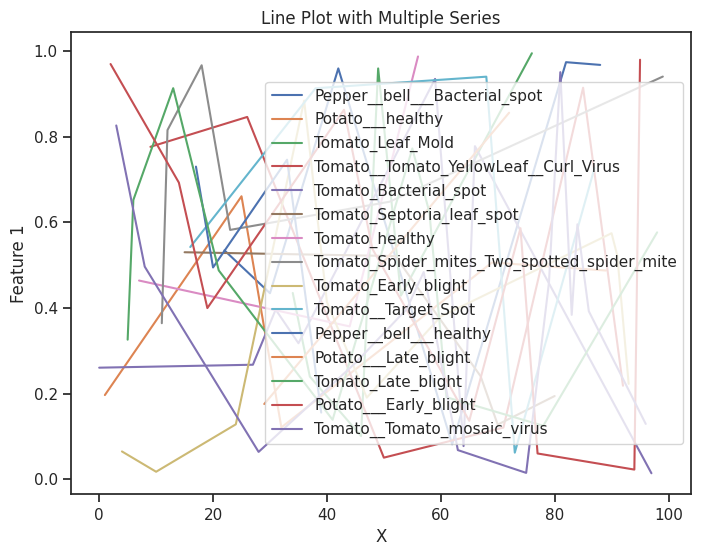

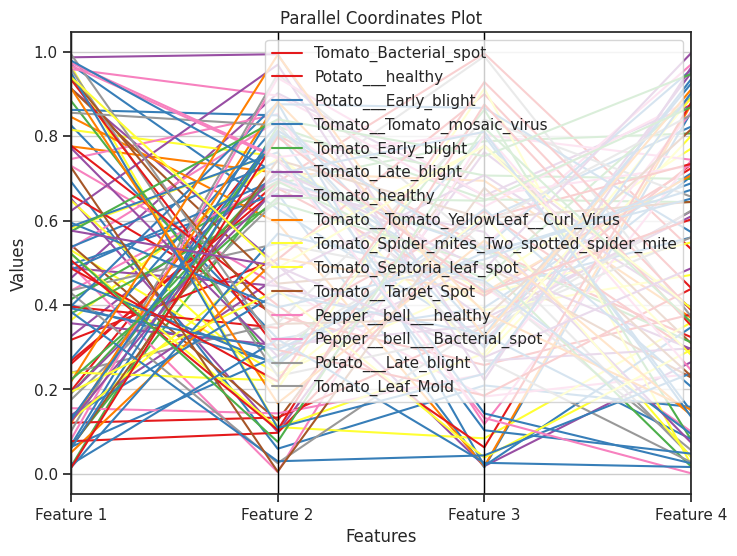

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Example data
class_labels = ['Pepper__bell___Bacterial_spot',
 'Potato___healthy',
 'Tomato_Leaf_Mold',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato_Bacterial_spot',
 'Tomato_Septoria_leaf_spot',
 'Tomato_healthy',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Tomato_Early_blight',
 'Tomato__Target_Spot',
 'Pepper__bell___healthy',
 'Potato___Late_blight',
 'Tomato_Late_blight',
 'Potato___Early_blight',
 'Tomato__Tomato_mosaic_virus']
data = pd.DataFrame(np.random.rand(100, 4), columns=['Feature 1', 'Feature 2', 'Feature 3', 'Feature 4'])
data['Class'] = np.random.choice(class_labels, size=100)

# Line Plot with Multiple Series
plt.figure(figsize=(8, 6))
for label in class_labels:
    plt.plot(data[data['Class'] == label]['Feature 1'], label=label)
plt.xlabel('X')
plt.ylabel('Feature 1')
plt.title('Line Plot with Multiple Series')
plt.legend()
plt.show()





# Parallel Coordinates Plot
plt.figure(figsize=(8, 6))
pd.plotting.parallel_coordinates(data, 'Class', colormap='Set1')
plt.xlabel('Features')
plt.ylabel('Values')
plt.title('Parallel Coordinates Plot')
plt.show()


ValueError: The number of FixedLocator locations (15), usually from a call to set_ticks, does not match the number of labels (3).

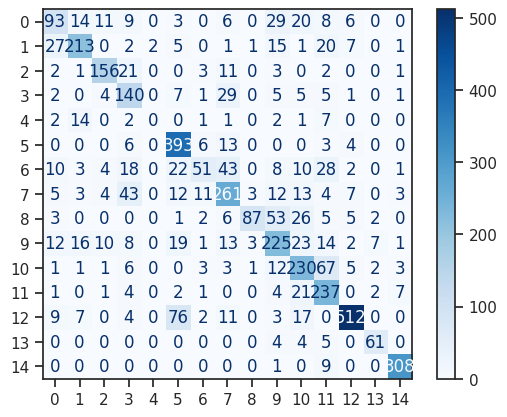

In [35]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay,classification_report
cm = confusion_matrix(test_data.classes, y_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)


disp.plot(cmap=plt.cm.Blues)
plt.show();

In [36]:
print(classification_report(test_data.classes, y_classes))

              precision    recall  f1-score   support

           0       0.56      0.47      0.51       199
           1       0.78      0.72      0.75       295
           2       0.82      0.78      0.80       200
           3       0.53      0.70      0.60       200
           4       0.00      0.00      0.00        30
           5       0.73      0.92      0.81       425
           6       0.62      0.26      0.36       200
           7       0.66      0.69      0.67       381
           8       0.92      0.46      0.61       190
           9       0.60      0.64      0.62       354
          10       0.62      0.69      0.65       335
          11       0.57      0.85      0.68       280
          12       0.93      0.80      0.86       641
          13       0.82      0.82      0.82        74
          14       0.94      0.97      0.96       318

    accuracy                           0.72      4122
   macro avg       0.67      0.65      0.65      4122
weighted avg       0.73   

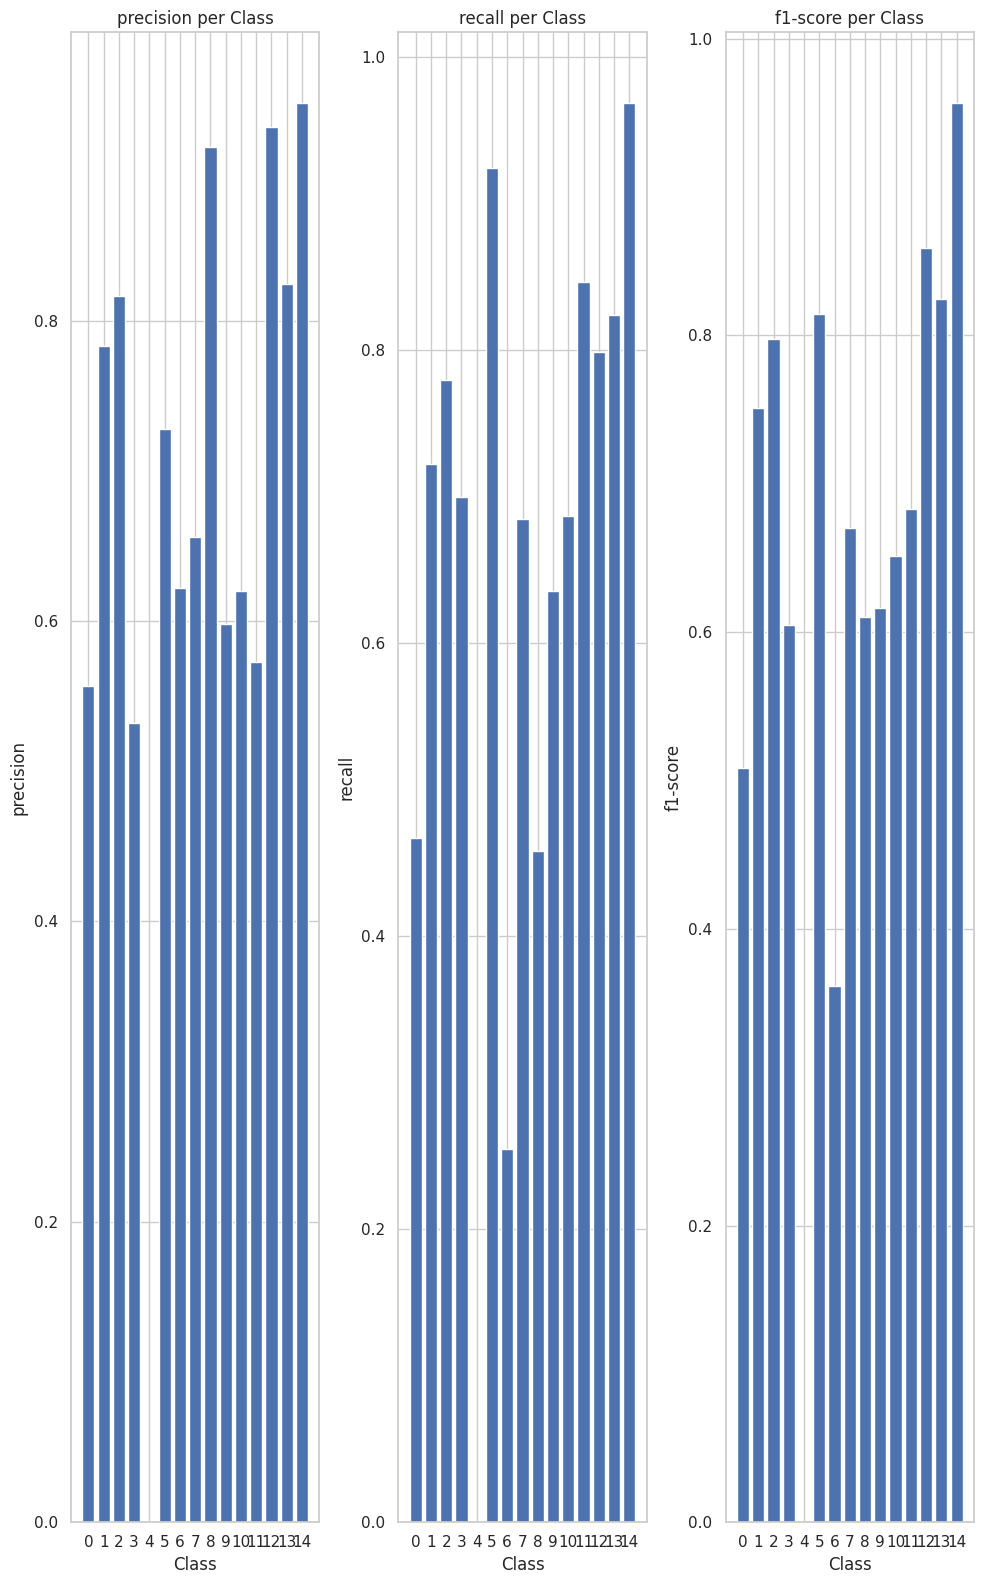

In [37]:
from sklearn.metrics import classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Generate classification report
report = classification_report(test_data.classes, y_classes, output_dict=True, zero_division=1)

# Extract precision, recall, F1-score for each class
class_labels = list(report.keys())[:-3]  # Exclude the 'macro avg', 'weighted avg', and 'accuracy' entries
metrics = ['precision', 'recall', 'f1-score']
values = [[report[label][metric] for metric in metrics] for label in class_labels]

# Create a bar plot
plt.figure(figsize=(10, 16))
sns.set_style("whitegrid")
for i, metric in enumerate(metrics):
    plt.subplot(1, 3, i + 1)
    plt.bar(class_labels, [v[i] for v in values])
    plt.xlabel('Class')
    plt.ylabel(metric)
    plt.title(f'{metric} per Class')
plt.tight_layout()
plt.show()


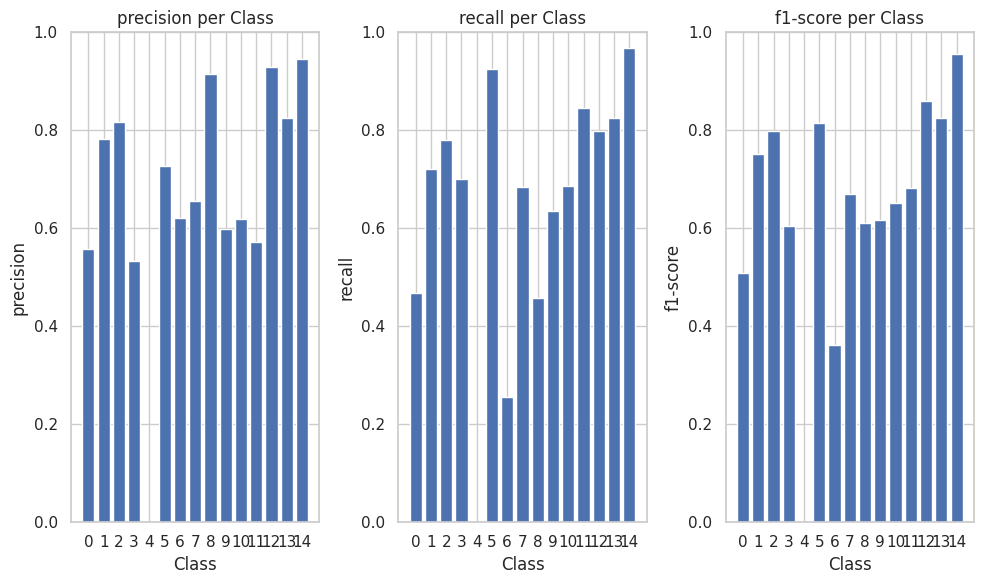

In [38]:
from sklearn.metrics import classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Generate classification report
report = classification_report(test_data.classes, y_classes, output_dict=True, zero_division=1)

# Extract precision, recall, F1-score for each class
class_labels = list(report.keys())[:-3]  # Exclude the 'macro avg', 'weighted avg', and 'accuracy' entries
metrics = ['precision', 'recall', 'f1-score']
values = [[report[label][metric] for metric in metrics] for label in class_labels]

# Create a bar plot
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")
for i, metric in enumerate(metrics):
    ax = plt.subplot(1, 3, i + 1)
    ax.bar(class_labels, [v[i] for v in values])
    ax.set_xlabel('Class')
    ax.set_ylabel(metric)
    ax.set_title(f'{metric} per Class')
    ax.set_ylim([0, 1])  # Set the y-axis limit to [0, 1] for better visualization
plt.tight_layout()
plt.show()


129/129 [==============================] - 18s 137ms/step


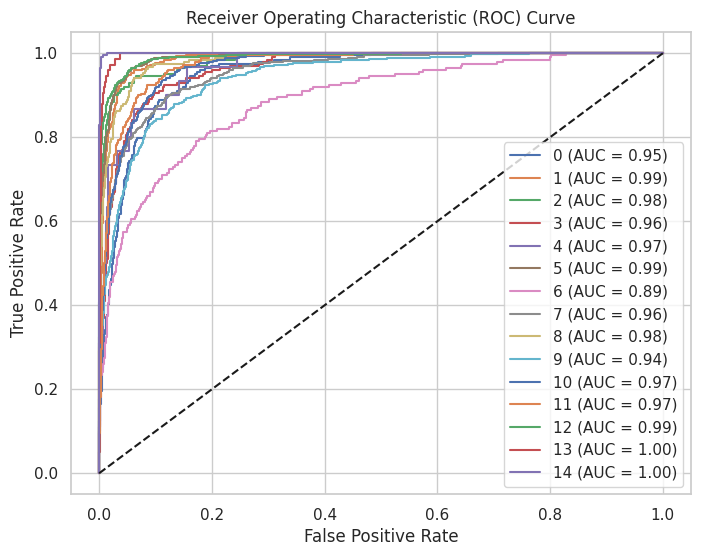

In [39]:
import numpy as np
from sklearn.metrics import roc_curve, auc

# Get the predicted probabilities for each class
y_pred = model.predict(test_data)
n_classes = y_pred.shape[1]

# Prepare the true labels in one-hot encoded format
y_true = np.eye(n_classes)[test_data.classes]

# Compute the ROC curve and AUC for each class
fpr = {}
tpr = {}
roc_auc = {}
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot the ROC curves
plt.figure(figsize=(8, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'{class_labels[i]} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


129/129 [==============================] - 14s 111ms/step


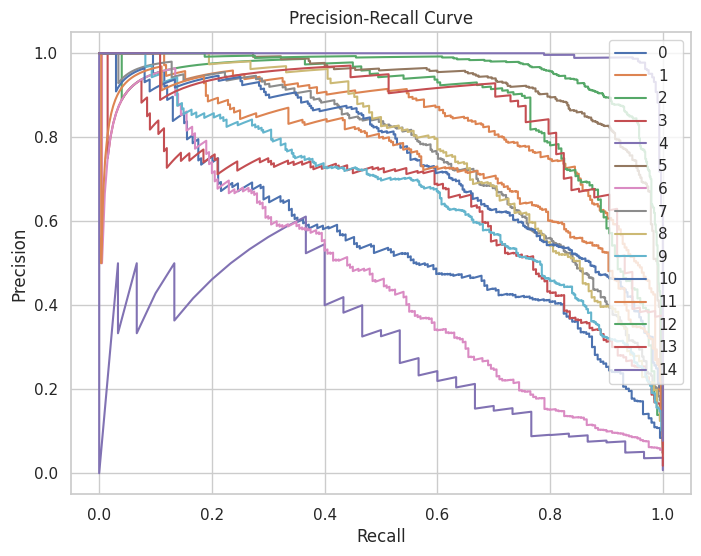

In [40]:
import numpy as np
from sklearn.metrics import precision_recall_curve

# Get the predicted probabilities for each class
y_pred = model.predict(test_data)
n_classes = y_pred.shape[1]

# Prepare the true labels in one-hot encoded format
y_true = np.eye(n_classes)[test_data.classes]

# Calculate the precision and recall for each class
precision = {}
recall = {}
thresholds = {}
for i in range(n_classes):
    precision[i], recall[i], thresholds[i] = precision_recall_curve(y_true[:, i], y_pred[:, i])

# Plot the Precision-Recall curves
plt.figure(figsize=(8, 6))
for i in range(n_classes):
    plt.plot(recall[i], precision[i], label=class_labels[i])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='upper right')
plt.show()


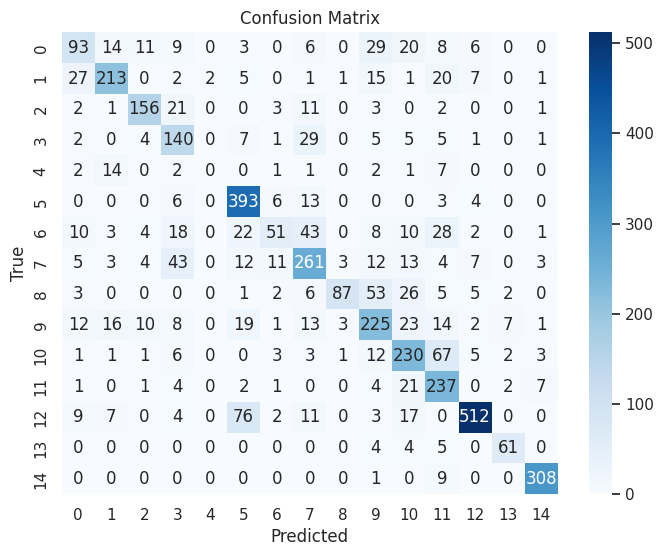

In [41]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the confusion matrix
cm = confusion_matrix(test_data.classes, y_classes)

# Create a heatmap of the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


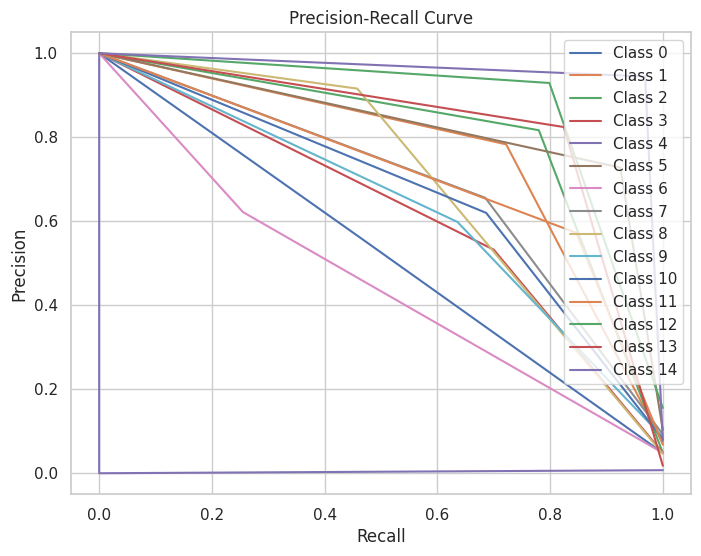

In [42]:
from sklearn.metrics import precision_recall_curve

# Calculate the precision and recall for each class
precision = {}
recall = {}
thresholds = {}
for i in range(len(class_labels)):
    precision[i], recall[i], thresholds[i] = precision_recall_curve(test_data.classes == i, y_classes == i)

# Plot the Precision-Recall curves
plt.figure(figsize=(8, 6))
for i in range(len(class_labels)):
    plt.plot(recall[i], precision[i], label='Class {}'.format(i))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='upper right')
plt.show()


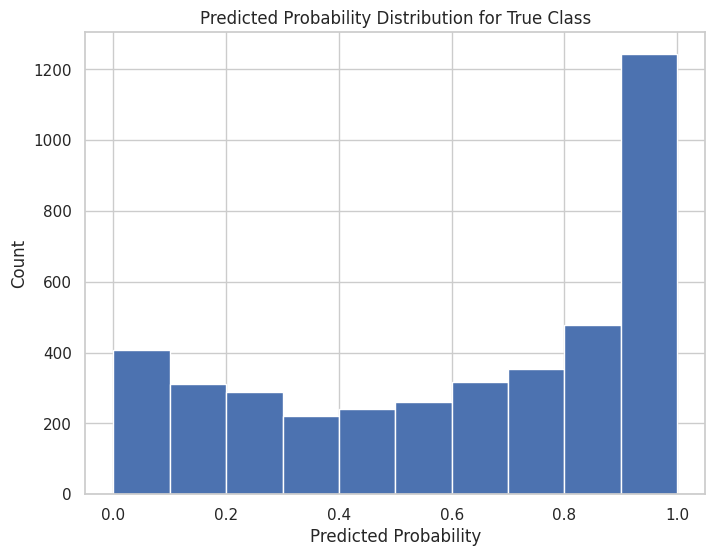

In [43]:
import matplotlib.pyplot as plt

# Get the predicted probabilities for the true class
true_class_probs = y_pred[np.arange(len(y_pred)), test_data.classes]

# Create a histogram
plt.figure(figsize=(8, 6))
plt.hist(true_class_probs, bins=10)
plt.xlabel('Predicted Probability')
plt.ylabel('Count')
plt.title('Predicted Probability Distribution for True Class')
plt.show()


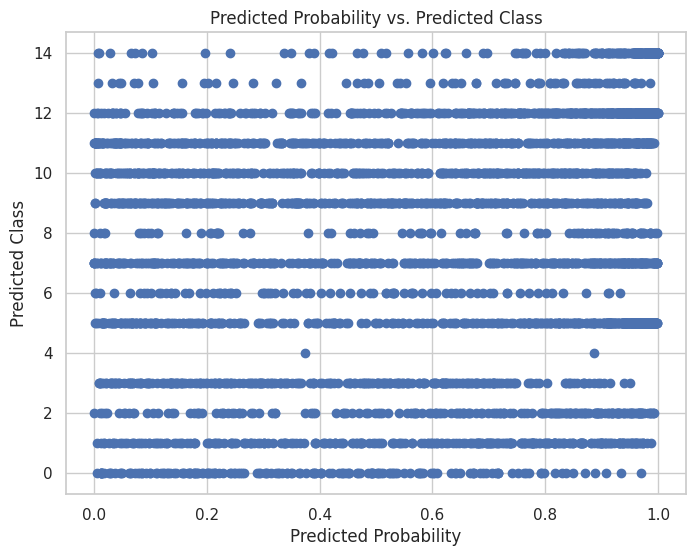

In [44]:
import matplotlib.pyplot as plt

# Get the predicted probabilities for the true class
true_class_probs = y_pred[np.arange(len(y_pred)), test_data.classes]

# Create a scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(true_class_probs, y_classes)
plt.xlabel('Predicted Probability')
plt.ylabel('Predicted Class')
plt.title('Predicted Probability vs. Predicted Class')
plt.show()


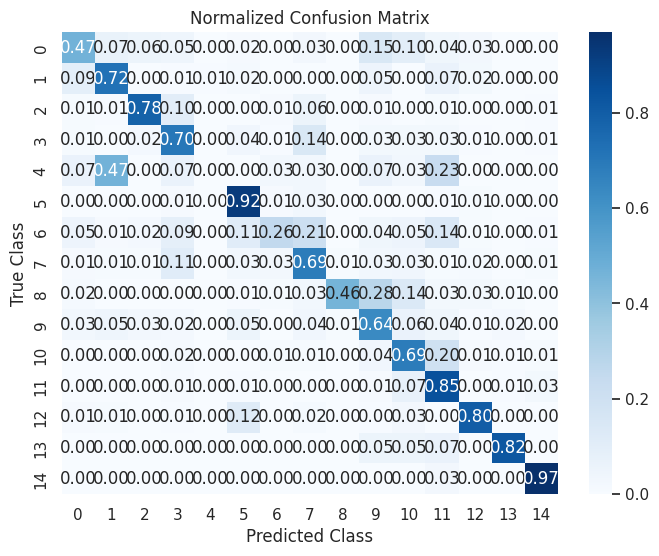

In [45]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the confusion matrix
confusion_matrix = np.zeros((len(class_labels), len(class_labels)))
for true_label, predicted_label in zip(test_data.classes, y_classes):
    confusion_matrix[true_label][predicted_label] += 1

# Normalize the confusion matrix
normalized_confusion_matrix = confusion_matrix / confusion_matrix.sum(axis=1, keepdims=True)

# Create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(normalized_confusion_matrix, annot=True, fmt=".2f", cmap="Blues")
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.title('Normalized Confusion Matrix')
plt.show()


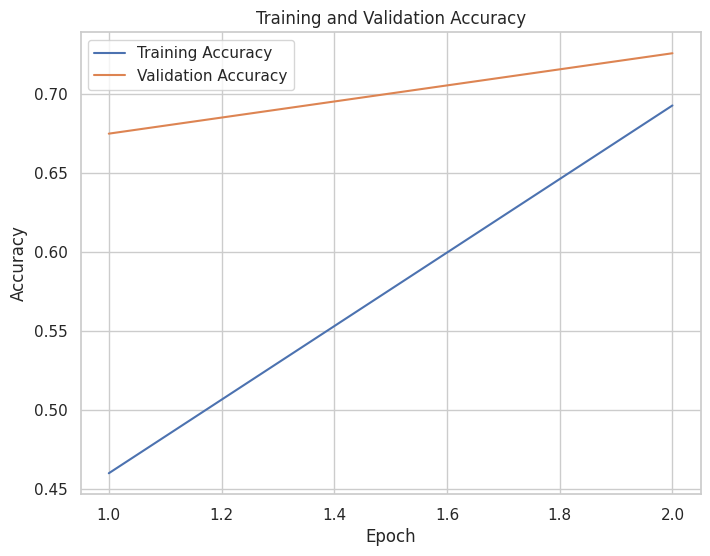

In [46]:
import matplotlib.pyplot as plt

# Get the training and validation accuracy over epochs
train_acc = base_model.history['accuracy']
val_acc = base_model.history['val_accuracy']
epochs = range(1, len(train_acc) + 1)

# Create a line plot
plt.figure(figsize=(8, 6))
plt.plot(epochs, train_acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()


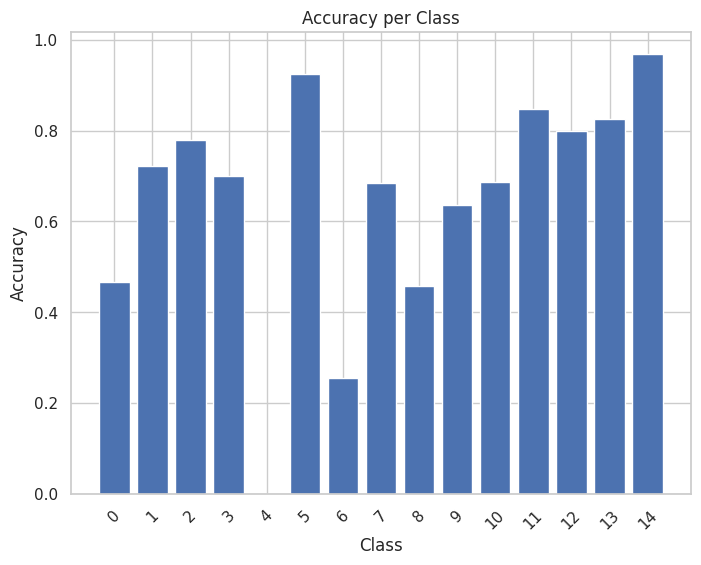

In [47]:
import matplotlib.pyplot as plt

# Calculate the accuracy for each class
accuracy_per_class = []
for i in range(len(class_labels)):
    class_samples = test_data.classes == i
    class_accuracy = np.mean(y_classes[class_samples] == test_data.classes[class_samples])
    accuracy_per_class.append(class_accuracy)

# Create a bar plot
plt.figure(figsize=(8, 6))
plt.bar(class_labels, accuracy_per_class)
plt.xlabel('Class')
plt.ylabel('Accuracy')
plt.title('Accuracy per Class')
plt.xticks(rotation=45)
plt.show()


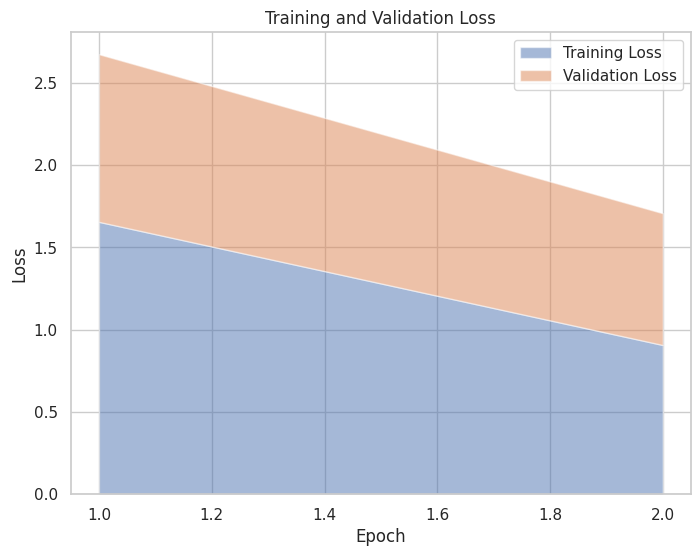

In [48]:
import matplotlib.pyplot as plt

# Get the training loss and validation loss over epochs
train_loss = base_model.history['loss']
val_loss = base_model.history['val_loss']
epochs = range(1, len(train_loss) + 1)

# Create an area plot
plt.figure(figsize=(8, 6))
plt.stackplot(epochs, train_loss, val_loss, labels=['Training Loss', 'Validation Loss'], alpha=0.5)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend(loc='upper right')
plt.show()


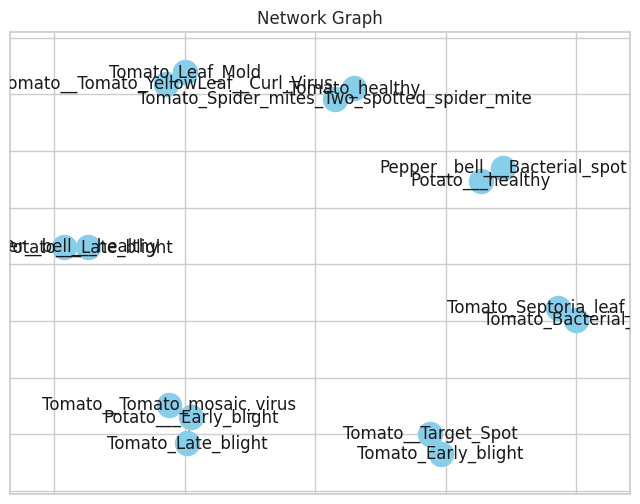

In [49]:
import networkx as nx
import matplotlib.pyplot as plt

# Define the nodes and edges
nodes = ['Pepper__bell___Bacterial_spot',
 'Potato___healthy',
 'Tomato_Leaf_Mold',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato_Bacterial_spot',
 'Tomato_Septoria_leaf_spot',
 'Tomato_healthy',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Tomato_Early_blight',
 'Tomato__Target_Spot',
 'Pepper__bell___healthy',
 'Potato___Late_blight',
 'Tomato_Late_blight',
 'Potato___Early_blight',
 'Tomato__Tomato_mosaic_virus']
edges = [('Pepper__bell___Bacterial_spot',
 'Potato___healthy'), ('Tomato_Leaf_Mold',
 'Tomato__Tomato_YellowLeaf__Curl_Virus'), ('Tomato_Bacterial_spot',
 'Tomato_Septoria_leaf_spot'), ('Tomato_healthy',
 'Tomato_Spider_mites_Two_spotted_spider_mite'), ('Tomato_Early_blight',
 'Tomato__Target_Spot'),('Pepper__bell___healthy',
 'Potato___Late_blight'),('Tomato_Late_blight',
 'Potato___Early_blight'), ('Potato___Early_blight',
 'Tomato__Tomato_mosaic_virus')]

# Create a graph object
G = nx.Graph()

# Add nodes and edges to the graph
G.add_nodes_from(nodes)
G.add_edges_from(edges)

# Draw the network graph
plt.figure(figsize=(8, 6))
pos = nx.spring_layout(G)  # Layout algorithm for arranging the nodes
nx.draw_networkx(G, pos, with_labels=True, node_color='skyblue', edge_color='gray')
plt.title('Network Graph')
plt.show()


In [50]:
!pip install plotly
!pip install pychord

In [51]:
from PIL import Image
import numpy as np

# Upload an image file
uploaded = files.upload()

# Get the uploaded image file
image_path = next(iter(uploaded))

# Load and preprocess the image
image = Image.open(image_path)
image = image.resize((64, 64))  # Resize the image to match the input shape of the model
image_array = np.array(image) / 255.0  # Normalize the image

# Reshape the image array to match the input shape of the model
image_array = np.expand_dims(image_array, axis=0)

# Make predictions using the model
predictions = model.predict(image_array)
predicted_class_index = np.argmax(predictions[0])

# Define the class labels
class_labels = ['Pepper__bell___Bacterial_spot',
 'Potato___healthy',
 'Tomato_Leaf_Mold',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato_Bacterial_spot',
 'Tomato_Septoria_leaf_spot',
 'Tomato_healthy',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Tomato_Early_blight',
 'Tomato__Target_Spot',
 'Pepper__bell___healthy',
 'Potato___Late_blight',
 'Tomato_Late_blight',
 'Potato___Early_blight',
 'Tomato__Tomato_mosaic_virus']

# Display the predicted class label
predicted_class_label = class_labels[predicted_class_index]
print("Predicted class:", predicted_class_label)

Saving 7a5fe2a0-ac85-4a37-b0f6-8cfc8fb21c9c___RS_HL 9865.JPG to 7a5fe2a0-ac85-4a37-b0f6-8cfc8fb21c9c___RS_HL 9865.JPG
1/1 [==============================] - 0s 110ms/step
Predicted class: Tomato_Leaf_Mold


In [ ]:
!pip install gradio

In [55]:
import gradio as gr
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.applications.vgg16 import VGG16
from PIL import Image

# Define the input shape
input_shape = (64, 64, 3)

# Load the pre-trained VGG16 model
vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

# Freeze the pre-trained layers so they are not trainable
for layer in vgg16.layers:
    layer.trainable = False

# Create a new model and add the pre-trained VGG16 model as the first layer
model = Sequential()
model.add(vgg16)

# Add additional layers to the model
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(15, activation='softmax'))  # Update the number of units to 8 for 8 classes===========================*********************************

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Define the class labels
class_labels = ['Pepper__bell___Bacterial_spot',
 'Potato___healthy',
 'Tomato_Leaf_Mold',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato_Bacterial_spot',
 'Tomato_Septoria_leaf_spot',
 'Tomato_healthy',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Tomato_Early_blight',
 'Tomato__Target_Spot',
 'Pepper__bell___healthy',
 'Potato___Late_blight',
 'Tomato_Late_blight',
 'Potato___Early_blight',
 'Tomato__Tomato_mosaic_virus']

def classify_image(image):
    # Preprocess the image
    image = Image.fromarray(image.astype('uint8'))
    image = image.resize((64, 64))
    image_array = np.array(image) / 255.0
    image_array = np.expand_dims(image_array, axis=0)

    # Make predictions using the model
    predictions = model.predict(image_array)
    predicted_class_index = np.argmax(predictions[0])

    # Get the predicted class label
    predicted_class_label = class_labels[predicted_class_index]

    return predicted_class_label

# Create the input and output interfaces
image_input = gr.Image()
label_output = gr.Textbox()

# Create the interface and run it
interface = gr.Interface(fn=classify_image, inputs=image_input, outputs=label_output)
interface.launch()


Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://83eaec4dab45735e5e.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


In [61]:
import gradio as gr
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.applications.vgg16 import VGG16
from PIL import Image

# Define the input shape
input_shape = (64, 64, 3)

# Load the pre-trained VGG16 model
vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

# Freeze the pre-trained layers so they are not trainable
for layer in vgg16.layers:
    layer.trainable = False

# Create a new model and add the pre-trained VGG16 model as the first layer
model = Sequential()
model.add(vgg16)

# Add additional layers to the model
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(15, activation='softmax'))  # Update the number of units to 8 for 8 classes==========================================*******************************

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Define the class labels
class_labels = ['Pepper__bell___Bacterial_spot',
 'Potato___healthy',
 'Tomato_Leaf_Mold',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato_Bacterial_spot',
 'Tomato_Septoria_leaf_spot',
 'Tomato_healthy',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Tomato_Early_blight',
 'Tomato__Target_Spot',
 'Pepper__bell___healthy',
 'Potato___Late_blight',
 'Tomato_Late_blight',
 'Potato___Early_blight',
 'Tomato__Tomato_mosaic_virus']

def classify_image(image):
    # Preprocess the image
    image = Image.fromarray(image.astype('uint8'))
    image = image.resize((64, 64))
    image_array = np.array(image) / 255.0
    image_array = np.expand_dims(image_array, axis=0)

    # Make predictions using the model
    predictions = model.predict(image_array)
    predicted_class_index = np.argmax(predictions[0])

    # Get the predicted class label
    predicted_class_label = class_labels[predicted_class_index]

    # Get the model's accuracy
    accuracy = predictions[0][predicted_class_index]

    return predicted_class_label, accuracy

# Create the input and output interfaces
image_input = gr.Image()
label_output = gr.Textbox()

# Create the interface and run it
interface = gr.Interface(fn=classify_image, inputs=image_input, outputs=label_output)
interface.launch()


Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://ee8ad7d1ca2f2ef3ca.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
